## Wot I Think About How Maps Should Work in Altair

### Big Ideas

1. We should encourage the use of TopoJSON as much as possible.  It works extremely well in D3, Bostock appears to be [continuing support](https://github.com/topojson/world-atlas) for it and there are some really compelling performance and size reasons to keep using it.  (I messed with a straight geojson file from Natural Earth and it was a pig in Jupyter. Topojson is much faster.)
2. Since the focus of Altair is *concise declarative syntax for statistical vizzes*, the big use case that I see is for thematic maps.  Which is great because the "nominal", "ordinal" and "quantitative" encoding color types seem to work great using VegaLite already. (I assume there is a way to define custom color ramps?)
3. We need an easy way (and syntax) to layer one map on top of another.  Like putting a city point layer with labels on top of a choropleth map of US County polygons, for example. Same idea as when you added a point plot to a line plot in your Convoy demo.
4. We need to be able to do a [lookup transform](https://vega.github.io/vega-lite/docs/lookup.html) between a defined topojson layer and a Pandas dataframe object.  I tried to figure out how to do that with the Unemployment data examples and couldn't.  I don't think we want to bring the topojson into Pandas and add columns to it there because it acts pretty strange in Pandas, but we definitely want to link to it from Pandas/Numpy/Python.  The lookup transform seems like a pretty clean interface to use, if we could wire it to read a Dataframe.
5. Probably need to support GeoJSON too, and I had a heck of a time figuring out the data format syntax in VegaLite to get it to pick up a feature type.  Need an example and some docs that describe how to work with a FeatureCollection.  The Lookup transform should work the same way for GeoJSON as in TopoJSON.

Below are the things I messed with.  I added some notes as comments in the code cells.

In [30]:
import pandas as pd
from vega3 import VegaLite
import json

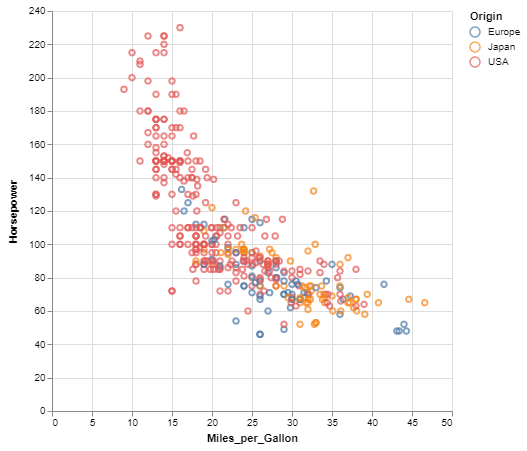

In [67]:
# I wanted to compare a VegaLite chart to an Altair one.  
# I had trouble getting Altair to work from the master branch, so I just did a cut
# and paste of an Altair code example.

df = pd.read_json('cars.json')

VegaLite({
  "mark": "point",
  "width": 400,
  "height": 400,
  "encoding": {
    "y": {"type": "quantitative","field": "Horsepower"},
    "x": {"type": "quantitative","field": "Miles_per_Gallon"},
    "color": {
        "field": "Origin",
        "type": "nominal"
      }
  }
}, df)

######################## Altair equivalent ########################
# cars = alt.load_dataset('cars')

# alt.Chart(cars).mark_circle().encode(
#    x='Horsepower',
#    y='Miles_per_Gallon',
#    color='Origin',
# )

In [68]:
# Read in the unemployment data into Pandas with the idea that I'd try passing in the df,
# as done in the VegaLite(specification, df) chart example above.

unemp_df = pd.read_csv('unemployment.tsv', sep='\t')

In [61]:
unemp_df.head()

,id,rate
0,1001,0.097
1,1003,0.091
2,1005,0.134
3,1007,0.121
4,1009,0.099


In [35]:
# Can we join the unemployment data to the topojson? [Not easily insofar as I could tell.]
# http://wrobstory.github.io/2013/10/mapping-data-python.html <--- doing something very similar
# https://stackoverflow.com/questions/33559660/error-while-reading-json-file <-- Making a df from json

with open('us-10m.json', 'r') as f:
    geom_json = json.load(f)

list(geom_json.keys())    

['type', 'objects', 'arcs', 'transform']

In [38]:
geom_df = pd.DataFrame.from_dict(geom_json, orient='index')
geom_df.head()
# I'm glad "it all just works" with TopoJson because I don't know how to
# make this structure of data using GeoJSON or shapefiles.

,0
type,Topology
objects,"{'counties': {'type': 'GeometryCollection', 'b..."
arcs,"[[[162416, 583189], [236, -863], [95, -3199], ..."
transform,"{'scale': [0.0003589261789261791, 5.3714868513..."


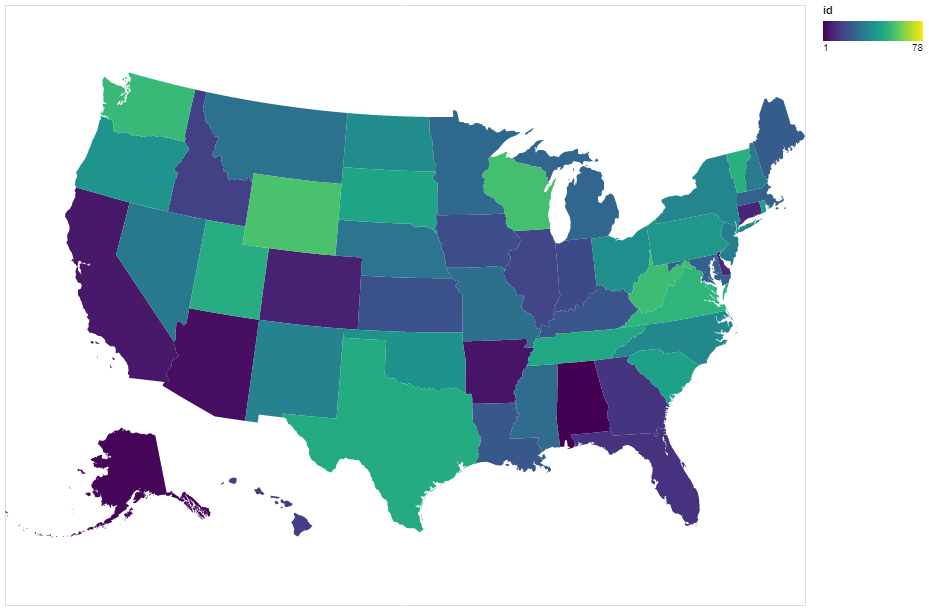

In [63]:
# I rearranged one of the VegaLite examples so that it was just
# working with a single data file. I then overloaded the "id" field to test
# encoding colors.  If the "rate" field had already been in the TopoJSON file,
# I could have styled it.  BUt I don't think that's a good way to go (adding data
# into the TopoJSON)

# color types can be one of: nominal, ordinal, quantitative

map_spec = {
  "mark": "geoshape",
  "width": 800,
  "height": 600,
  "projection": {"type": "albersUSA"},
  "data": {
      "url": "us-10m.json",
      "format": {
          "type": "topojson",
          "feature": "states"
      }
  },
  "encoding": {
      "color": {
          "field": "id",
          "type": "quantitative"
      }
  }
}

VegaLite(map_spec)

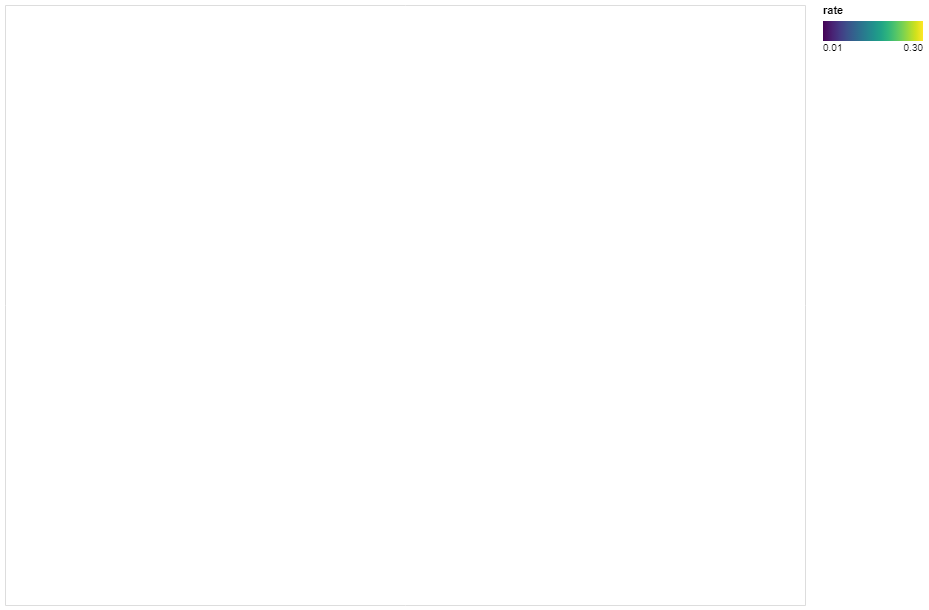

In [69]:
# Here I messed around with what happens when you pass in the df with the specification to VegaLite.
# No map, but you can see that the rate column is being read and used for the legend.

map_df_spec = {
  "mark": "geoshape",
  "width": 800,
  "height": 600,
  "projection": {"type": "albersUSA"},
  "data": {
      "url": "us-10m.json",
      "format": {
          "type": "topojson",
          "feature": "states"
      }
  },
  "encoding": {
      "color": {
          "field": "rate",
          "type": "quantitative"
      }
  }
}

VegaLite(map_df_spec, unemp_df)

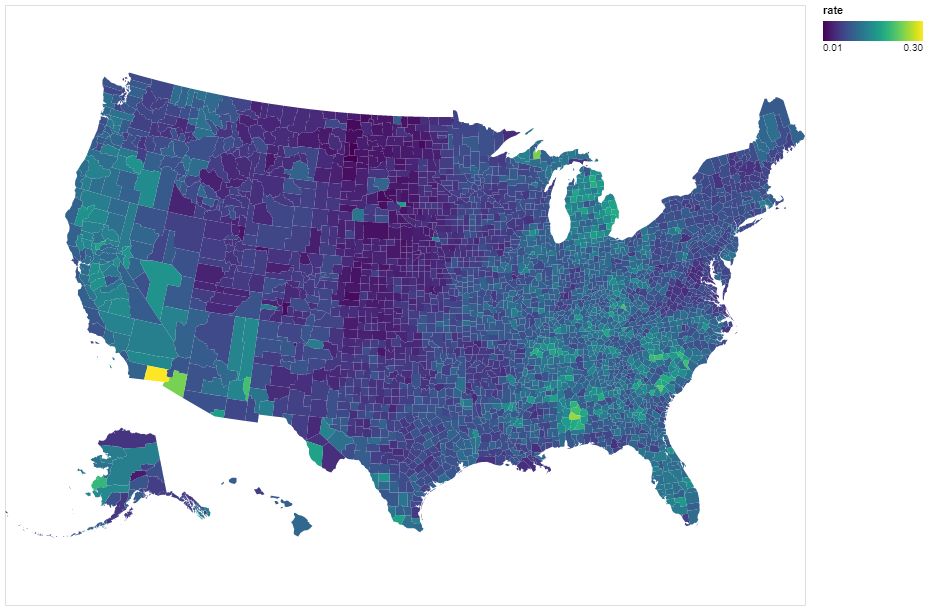

In [70]:
# Working VegaLite choropleth spec rearranged so that map geom info is
# all at the top and the transform and stat data encoding is all at the 
# bottom.  This seemed to make more sense to me.

choro_map_spec = {
  "mark": "geoshape",
  "width": 800,
  "height": 600,
  "projection": {"type": "albersUSA"},
  "data": {
      "url": "us-10m.json",
      "format": {
          "type": "topojson",
          "feature": "counties"
      }
  },
  "transform": [{
    "lookup": "id",
    "from": {
      "data": {
        "url": "unemployment.tsv"
      },
      "key": "id",
      "fields": ["rate"]
    }
  }], 
  "encoding": {
    "color": {
      "field": "rate",
      "type": "quantitative"
    }
  }
}

VegaLite(choro_map_spec)